In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential as box_seq
from tensorflow.keras.layers import Dense, Dropout, Flatten

<h1> 
    Реализация своего маленького фреймворка <br/>
    для обучения нейронных сетей 
</h1>

<h2> 
    1. Активация
</h2>

In [2]:
class Layer: pass


class Layer:
    def __init__(self): 
        self.z = None
        self.dZ = None
        
    def forwardPass(self, X): pass  
    
    def backProp(self, dZ, prev_layer = None): pass
    
    def update(self, lr): pass


class ReLU(Layer):    
    def forwardPass(self, X):
        self.z = np.maximum(X, 0)
        return self.z    
    
    def backProp(self, dZ = None, prev_layer = None):  
        self.dZ = dZ
        return self.dZ * np.maximum(prev_layer.z , 0) / prev_layer.z
    
    
class LeakyReLU(Layer):
    def __init__(self, k=0.01):
        self.k = k
        
    def forwardPass(self, X):          
        self.z = np.multiply(X, np.where(X < 0, self.k, 1)) 
        return  self.z    
    
    def backProp(self, dZ = None, prev_layer = None):
        self.dZ = dZ        
        return self.dZ*np.where(prev_layer.z < 0, self.k, 1)
    
    
class SoftPlus(Layer):   
    def forwardPass(self, X):
        self.z = np.log(1 + np.exp(X))
        return self.z  
    
    def backProp(self, dZ = None, prev_layer = None):
        self.dZ = dZ
        return self.dZ * 1/(1+np.exp(-prev_layer.z))
    

class Sigmoid(Layer):    
    def forwardPass(self, X):
        self.z = 1/(1+np.exp(-X))
        return self.z
    
    def backProp(self, dZ = None, prev_layer = None):
        self.dZ = dZ
        return self.dZ * self.forwardPass(prev_layer.z) * self.forwardPass(1-prev_layer.z)
    

def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats. 
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the 
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter, 
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)
    
    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p
    
                 
class SoftMax(Layer):
    def forwardPass(self, X):
        self.z = softmax(X, axis=1)
        return self.z
    
    def backProp(self, dZ, prev_layer = None):
        return self.z - dZ

<h2> 
    2. Слои
</h2>

In [3]:
class Dense(Layer):
    def __init__(self, layer_quantity, activation=None):
        self.W = None
        self.b = None
        self.dW = None
        self.db = None
        self.l_quant = layer_quantity
        self.disp = 1/np.sqrt(layer_quantity)  
        
    def forwardPass(self, X):
        if self.W is None:
            self.W = np.random.uniform(-self.disp, self.disp, size = (X.shape[1], self.l_quant))
            self.b = np.random.uniform(-self.disp, self.disp, size = (1, self.l_quant))
        self.z = X@self.W + self.b
        return self.z    
    
    def backProp(self, dz, prev_layer = None):
        self.dz = dz
        self.db = self.dz.sum(0) / self.z.shape[0]
        self.dW = prev_layer.z.T@self.dz / self.z.shape[0]
        return self.dz @ self.W.T    
    
    def update(self, lr):
        self.W = self.W - self.dW * lr
        self.b = self.b - self.db * lr     
    

class Flatten(Layer):
    def forwardPass(self, X):
        self.z = X
        return self.z    


class Dropout(Layer):
    def __init__(self, prob_rate = 0.5):
        self.z = None
        self.mask = None
        self.rate = prob_rate 
        
    def forwardPass(self, X):
        self.z = X
        self.mask = np.random.choice([0, 1], size=X.shape, p=[self.rate, 1-self.rate])
        return X * self.mask 
    
    def backProp(self, dz, prev_layer = None):
        return dz * self.mask    
    
    def update(self, lr): pass

<h2> 
    3. Нейросеть
</h2>

In [4]:
def crossEntropyLoss(y_real, y_pred):
    return -np.sum(np.log(y_pred) * y_real)

class Sequential:
    def __init__(self, epochs=16, batch_size=128, lr=0.1, lr_dec=0.01, epoch_decrease=4):
        self.epochs = epochs              
        self.batch_size = batch_size            
        self.lr = lr                      
        self.lr_decrease = lr_dec    
        self.epochs_decrease = epoch_decrease    
        self.layers = list()             
        self._encoder = OneHotEncoder(sparse=False,categories='auto') 
        self.history = {'loss': list(), 'accuracy': list()}
                        
    def add(self, layer): 
        self.layers.append(layer)
    
    def _forwardPass(self, X):
        prev_output = X
        for layer_ind in self.layers:
            prev_output = layer_ind.forwardPass(prev_output)
        return prev_output
    
    def _backProp(self, X, y):
        dZ = y
        for index in range(len(self.layers)-1,0,-1):
            dZ = self.layers[index].backProp(dZ, prev_layer=self.layers[index-1])    
    
    def stepDecrease(self, init_lr, epoch):
        drop = self.lr_decrease
        lr = init_lr * np.power(drop,np.floor((1+epoch)/self.epochs_decrease))
        return lr
    
    def _update(self, epoch):
        for layer_ind in self.layers:
            layer_ind.update(self.stepDecrease(self.lr, epoch))
            
    def predict(self, X):
        prediction = self._forwardPass(X)
        return np.argmax(prediction, axis=1)
    
    def evalute(self, X, Y):
        return(accuracy_score(self.predict(X),Y))
    
    def plotRes(self, x_train, x_test):
        print("TRAIN loss :", self.history['loss'][len(self.history['loss'])-1::])
        print("TRAIN accuracy:", self.history['accuracy'][len(self.history['accuracy'])-1::])
        print("TEST accuracy:", self.evalute(x_train, x_test))
        plt.plot(self.history['accuracy'])
        plt.title('accuracy')
        plt.xlabel('Epoch')
        plt.show()
        plt.plot(self.history['loss'])
        plt.title('loss func')
        plt.xlabel('Epoch')
        plt.show()
        
    def fit(self, X, y=None):
        y_old = np.copy(y)
        y = self._encoder.fit_transform(y)
        for epoch in range(self.epochs):
            for ind in range(len(X) // self.batch_size):
                self._forwardPass(X[ind * self.batch_size:(ind+1) * self.batch_size])
                self._backProp(X[ind * self.batch_size:(ind+1) * self.batch_size], y[ind * self.batch_size:(ind+1) * self.batch_size])
                self._update(epoch)
        
            self.history['accuracy'].append(accuracy_score(y_old, self.predict(X)))
            self.history['loss'].append(log_loss(y, self._forwardPass(X)))

<h1> 
    Подгружаем датасет    
</h1>

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0],-1) / 255.0
x_test = x_test.reshape(x_test.shape[0],-1) / 255.0
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

<h2>Решение из коробки</h2>

In [6]:
box_model = box_seq()
box_model.add(Flatten())
box_model.add(Dense(128, activation=tf.nn.relu))
box_model.add(Dense(10, activation=tf.nn.softmax))


box_model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
box_model.fit(x=x_train,y=y_train, batch_size=128, epochs=16)
box_model.evaluate(x_test, y_test)

Epoch 1/16
60000/60000 [==============================] - 1s 21us/sample - loss: 1.1706 - acc: 0.7200
Epoch 2/16
60000/60000 [==============================] - 1s 17us/sample - loss: 0.5458 - acc: 0.8645
Epoch 3/16
60000/60000 [==============================] - 1s 17us/sample - loss: 0.4390 - acc: 0.8838
Epoch 4/16
60000/60000 [==============================] - 1s 17us/sample - loss: 0.3914 - acc: 0.8936
Epoch 5/16
60000/60000 [==============================] - 1s 17us/sample - loss: 0.3626 - acc: 0.9001
Epoch 6/16
60000/60000 [==============================] - 1s 19us/sample - loss: 0.3420 - acc: 0.9045
Epoch 7/16
60000/60000 [==============================] - 1s 18us/sample - loss: 0.3262 - acc: 0.9086
Epoch 8/16
60000/60000 [==============================] - 1s 18us/sample - loss: 0.3135 - acc: 0.9122
Epoch 9/16
60000/60000 [==============================] - 1s 17us/sample - loss: 0.3026 - acc: 0.9149
Epoch 10/16
60000/60000 [==============================] - 1s 18us/sample - loss: 

[0.24125840497016907, 0.9326]

<h1> 
    Испытания собственного решения
</h1>

<h2> 
    1. Двухслойная нейросеть
</h2>

<h3> 
    1.1 Без Dropout
</h3>

<h4> 
    1.1.1 Sigmoid
</h4>

TRAIN loss : [0.3150576397808517]
TRAIN accuracy: [0.9108166666666667]
TEST accuracy: 0.9145


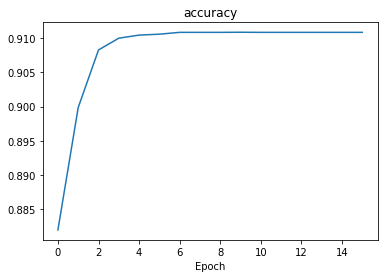

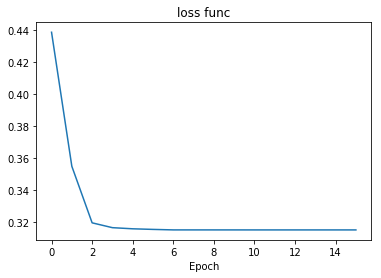

In [8]:
NN = Sequential()
NN.add(Flatten())
NN.add(Dense(128))
NN.add(Sigmoid())
NN.add(Dense(10))
NN.add(SoftMax())

NN.fit(x_train, y_train)
NN.plotRes(x_test, y_test)

<h4> 
    1.1.2 ReLU
</h4>

TRAIN loss : [0.15954788868844097]
TRAIN accuracy: [0.9555833333333333]
TEST accuracy: 0.9545


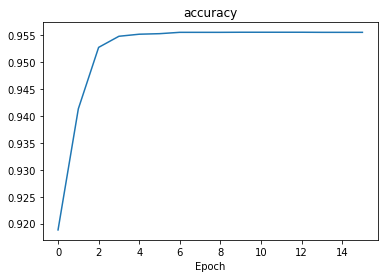

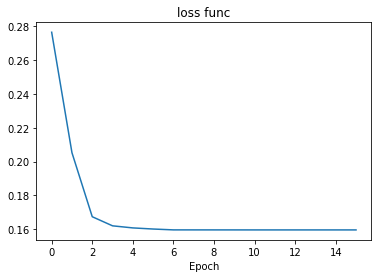

In [9]:
NN = Sequential()
NN.add(Flatten())
NN.add(Dense(128))
NN.add(ReLU())
NN.add(Dense(10))
NN.add(SoftMax())

NN.fit(x_train, y_train)
NN.plotRes(x_test, y_test)

<h4> 
    1.1.3 Leaky ReLU
</h4>

TRAIN loss : [0.15744145109107432]
TRAIN accuracy: [0.9566333333333333]
TEST accuracy: 0.9546


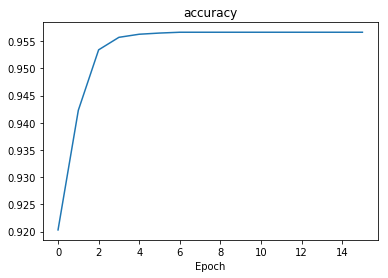

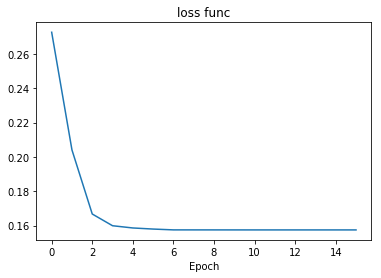

In [10]:
NN = Sequential()
NN.add(Flatten())
NN.add(Dense(128))
NN.add(LeakyReLU())
NN.add(Dense(10))
NN.add(SoftMax())

NN.fit(x_train, y_train)
NN.plotRes(x_test, y_test)

<h4> 
    1.1.4 SoftPlus
</h4>

TRAIN loss : [0.24726644109300513]
TRAIN accuracy: [0.9302333333333334]
TEST accuracy: 0.9292


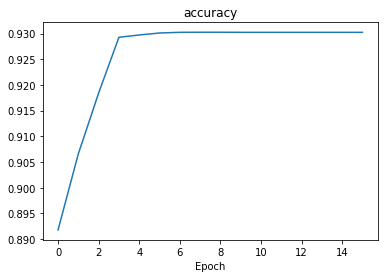

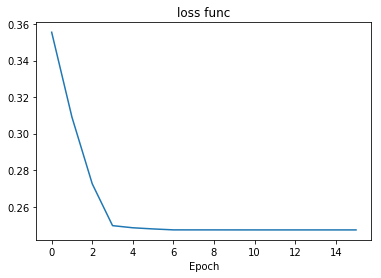

In [11]:
NN = Sequential()
NN.add(Flatten())
NN.add(Dense(128))
NN.add(SoftPlus())
NN.add(Dense(10))
NN.add(SoftMax())

NN.fit(x_train, y_train)
NN.plotRes(x_test, y_test)

<h3> 
    1.2 C Dropout
</h3>

TRAIN loss : [0.22225310489722422]
TRAIN accuracy: [0.9343333333333333]
TEST accuracy: 0.9368


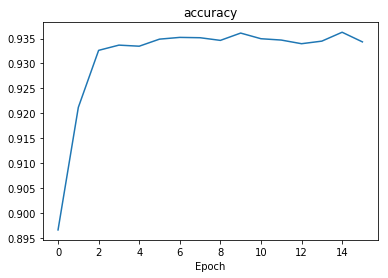

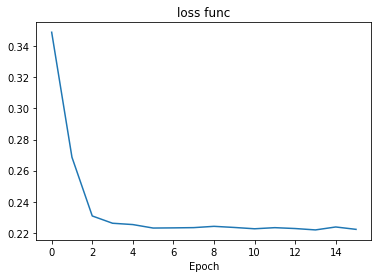

In [12]:
NN = Sequential()
NN.add(Flatten())
NN.add(Dense(128))
NN.add(ReLU())
NN.add(Dropout(.3))
NN.add(Dense(10))
NN.add(SoftMax())

NN.fit(x_train, y_train)
NN.plotRes(x_test, y_test)

TRAIN loss : [0.35790375066808633]
TRAIN accuracy: [0.89245]
TEST accuracy: 0.8917


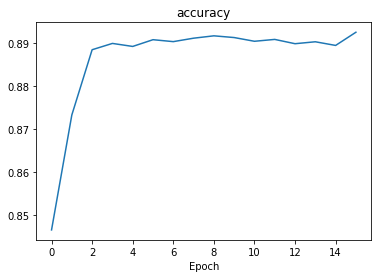

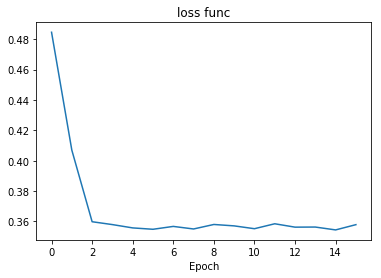

In [13]:
NN = Sequential()
NN.add(Flatten())
NN.add(Dense(128))
NN.add(SoftPlus())
NN.add(Dropout(.3))
NN.add(Dense(10))
NN.add(SoftMax())

NN.fit(x_train, y_train)
NN.plotRes(x_test, y_test)

<h2> 
    2. Трехслойная нейросеть
</h2>

<h3> 
    2.1 Без Dropout
</h3>

TRAIN loss : [0.25894689082815]
TRAIN accuracy: [0.9237333333333333]
TEST accuracy: 0.9271


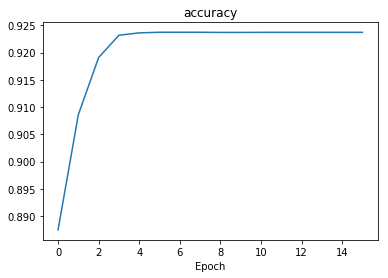

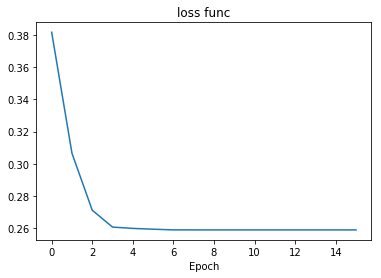

In [14]:
NN = Sequential()
NN.add(Flatten())
NN.add(Dense(64))
NN.add(SoftPlus())
NN.add(Dense(128))
NN.add(Sigmoid())
NN.add(Dense(10))
NN.add(SoftMax())

NN.fit(x_train, y_train)
NN.plotRes(x_test, y_test)

<h3> 
    2.2 C Dropout
</h3>

TRAIN loss : [0.25897008078027606]
TRAIN accuracy: [0.9233166666666667]
TEST accuracy: 0.9241


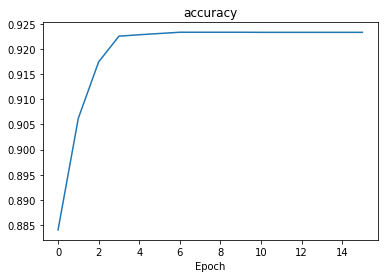

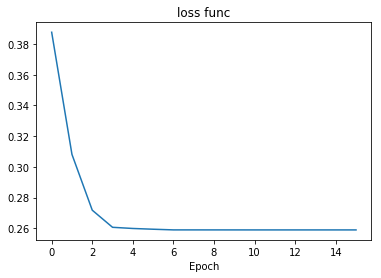

In [15]:
NN = Sequential()
NN.add(Flatten())
NN.add(Dense(64))
NN.add(SoftPlus())
NN.add(Dense(128))
NN.add(Sigmoid())
AN.add(Dropout(0.3))
NN.add(Dense(10))
NN.add(SoftMax())

NN.fit(x_train, y_train)
NN.plotRes(x_test, y_test)